<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW4_woodenML_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 27 января 23:59

**Продуктивной и интересной вам работы!**


In [4]:
# %pip install optuna
# %pip install lime
# %pip install shap
# %pip install psycopg2

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')
import psycopg2
import psycopg2.extras
import shap
import optuna
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import gc; gc.collect()

896

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [8]:
from hw4_code_pro import find_best_split

In [10]:
# proof of realization
help(find_best_split)

Help on function find_best_split in module hw4_code_pro:

find_best_split(feature_vector, target_vector)
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -rac {|R_l|}{|R|}H(R_l) -rac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.
    
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)
    
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) ==

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [11]:
df_students = pd.read_csv("students.csv")
display(df_students.head())
display(df_students.shape)

features = df_students.columns[:-1]
target = "UNS"

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


(258, 6)

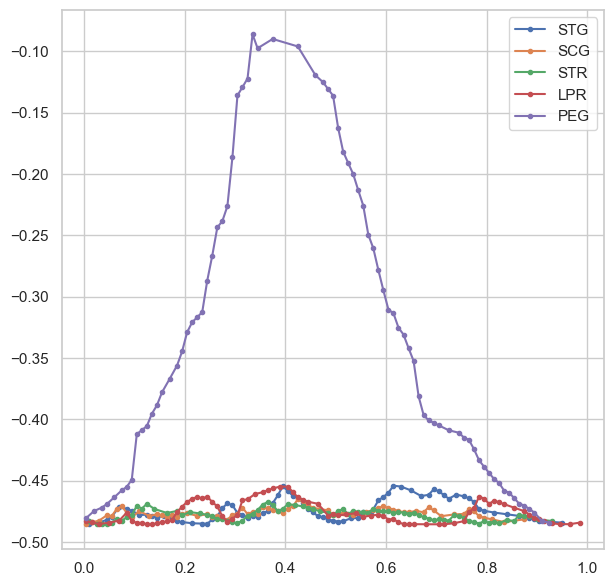

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
for feat in features:
    threash, gini, _, _ = find_best_split(df_students[feat].values, df_students[target].values)
    ax.plot(threash, gini, label=feat, marker=".")

ax.legend()

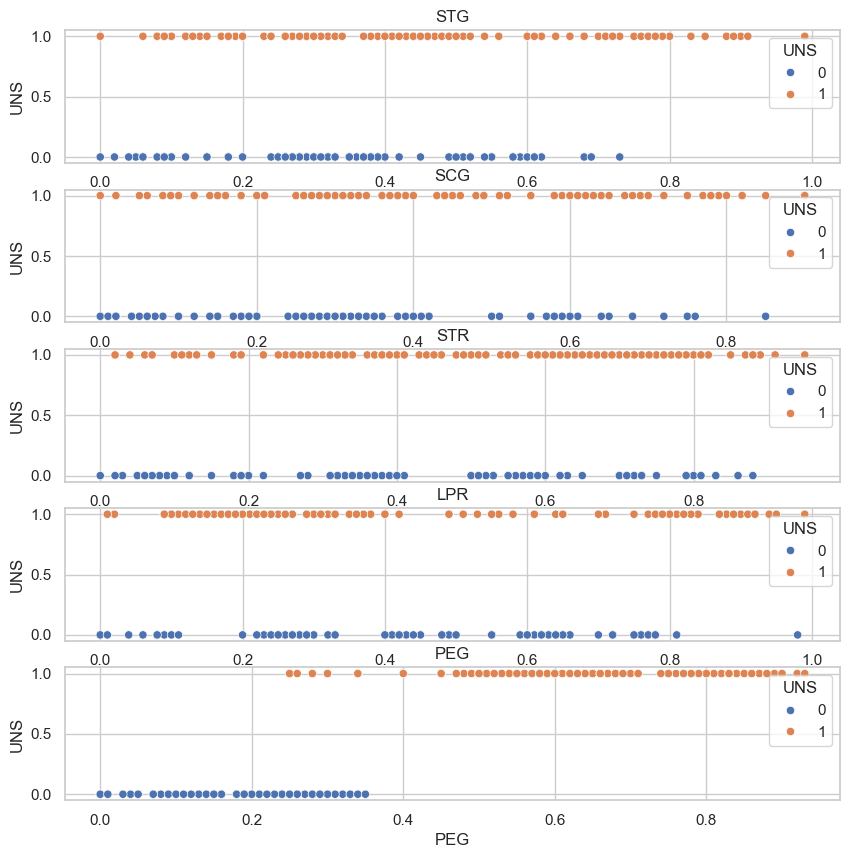

In [6]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 10))
for i, feat in enumerate(features):
    sns.scatterplot(df_students, x=feat, y=target, hue=target, ax=ax[i])
    ax[i].set_title(feat)

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

Ответ:

График Джини показывает, что оптимальное разделение выборки достигается при использовании признака PEG с пороговым значением около 0.4.

Это подтверждается визуальным анализом: scatter-plot признака PEG практически идеально разделяет целевой показатель на два класса.

В идеале такие кривые должны иметь форму колокола, то есть резко возрастать при приближении к оптимальному разделению.

Кривые, которые не позволяют эффективно разделить данные, обычно имеют несколько максимумов, но ни один из них не является четко выраженным.

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


In [13]:
from hw4_code_pro import DecisionTree

In [15]:
help(DecisionTree)

Help on class DecisionTree in module hw4_code_pro:

class DecisionTree(sklearn.base.BaseEstimator)
 |  DecisionTree(feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None)
 |  
 |  Method resolution order:
 |      DecisionTree
 |      sklearn.base.BaseEstimator
 |      sklearn.utils._estimator_html_repr._HTMLDocumentationLinkMixin
 |      sklearn.utils._metadata_requests._MetadataRequester
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X, y)
 |  
 |  get_params(self, *args, **kwargs)
 |      Get parameters for this estimator.
 |      
 |      Parameters
 |      ----------
 |      deep : bool, default=True
 |          If True, will return the parameters for this estimator and
 |          contained subobjects that are estimators.
 |      
 |      Returns
 |      -------

### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [16]:
RANDOM_STATE = 5252

In [17]:
# Ваш код здесь
df_mush = pd.read_csv("agaricus-lepiota.data", names=["target"] + [f"col_{i}" for i in range(22)])

features = df_mush.columns[1:].values
target = "target"

display(df_mush.head())
df_mush.shape

,target,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


(8124, 23)

In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

oe = OrdinalEncoder()
oe.set_output(transform="pandas")

df_mush = oe.fit_transform(df_mush)
df_mush.head()

,target,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,1.0,5.0,2.0,4.0,1.0,6.0,1.0,0.0,1.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
1,0.0,5.0,2.0,9.0,1.0,0.0,1.0,0.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,1.0
2,0.0,0.0,2.0,8.0,1.0,3.0,1.0,0.0,0.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,3.0
3,1.0,5.0,3.0,8.0,1.0,6.0,1.0,0.0,1.0,5.0,...,2.0,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0
4,0.0,5.0,2.0,3.0,0.0,5.0,1.0,1.0,0.0,4.0,...,2.0,7.0,7.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_mush[features].values,df_mush[target].values,random_state=RANDOM_STATE, stratify=df_mush[target],test_size=0.2)

In [20]:
dt = DecisionTree( feature_types=["categorical"] * X_train.shape[1] )
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [21]:
display(dt._tree)
print("Accuracy:", accuracy_score(y_test, y_pred))

{'type': 'nonterminal',
 'feature_split': 4,
 'categories_split': [0.0, 3.0, 5.0],
 'left_child': {'type': 'nonterminal',
  'feature_split': 19,
  'categories_split': [3.0, 2.0, 4.0, 8.0, 0.0, 6.0, 1.0, 7.0],
  'left_child': {'type': 'nonterminal',
   'feature_split': 14,
   'categories_split': [3.0, 6.0, 2.0, 5.0, 7.0, 4.0],
   'left_child': {'type': 'nonterminal',
    'feature_split': 1,
    'categories_split': [2.0, 0.0, 3.0],
    'left_child': {'type': 'nonterminal',
     'feature_split': 14,
     'categories_split': [3.0, 6.0, 2.0, 5.0, 7.0],
     'left_child': {'type': 'nonterminal',
      'feature_split': 0,
      'categories_split': [2.0, 5.0, 4.0, 0.0, 3.0],
      'left_child': {'type': 'nonterminal',
       'feature_split': 21,
       'categories_split': [1.0, 0.0, 3.0, 6.0, 5.0, 4.0],
       'left_child': {'type': 'terminal', 'class': 0.0},
       'right_child': {'type': 'nonterminal',
        'feature_split': 1,
        'categories_split': [2.0],
        'left_child': {'typ

Accuracy: 1.0


### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [22]:
df_tic_tac = pd.read_csv("tic-tac-toe.data", names=[f"col_{i}" for i in range(9)] + ["target"])
features = df_tic_tac.columns[:-1].values
target = "target"
display(df_tic_tac.head())
df_tic_tac.shape

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,target
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


(958, 10)

In [23]:
oe = OrdinalEncoder()
oe.set_output(transform="pandas")

df_tic_tac = oe.fit_transform(df_tic_tac)
df_tic_tac.head()
X_train, X_test, y_train, y_test = train_test_split(df_tic_tac[features].values, df_tic_tac[target].values,random_state=RANDOM_STATE, stratify=df_tic_tac[target], test_size=0.2)

In [24]:
max_depths = np.arange(10)
min_samples_splits = np.arange(0, 30, 2)
min_samples_leaves = np.arange(0, 30, 2)

In [25]:
acc_depths = []
acc_samples_splits = []
acc_samples_leaves = []

for depth in tqdm(max_depths):
    dt = DecisionTree(feature_types=["categorical"] * X_train.shape[1], max_depth=depth)

    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc_depths.append(accuracy_score(y_test, y_pred))
    
for samples_splits in tqdm(min_samples_splits):
    dt = DecisionTree(
        feature_types=["categorical"] * X_train.shape[1], min_samples_split=samples_splits
    )

    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc_samples_splits.append(accuracy_score(y_test, y_pred))
    
for samples_leaves in tqdm(min_samples_leaves):
    dt = DecisionTree(
        feature_types=["categorical"] * X_train.shape[1], min_samples_leaf=samples_leaves
    )

    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc_samples_leaves.append(accuracy_score(y_test, y_pred))

100%|██████████| 15/15 [00:00<00:00, 16.67it/s]


Text(0.5, 1.0, 'min_samples_leaf')

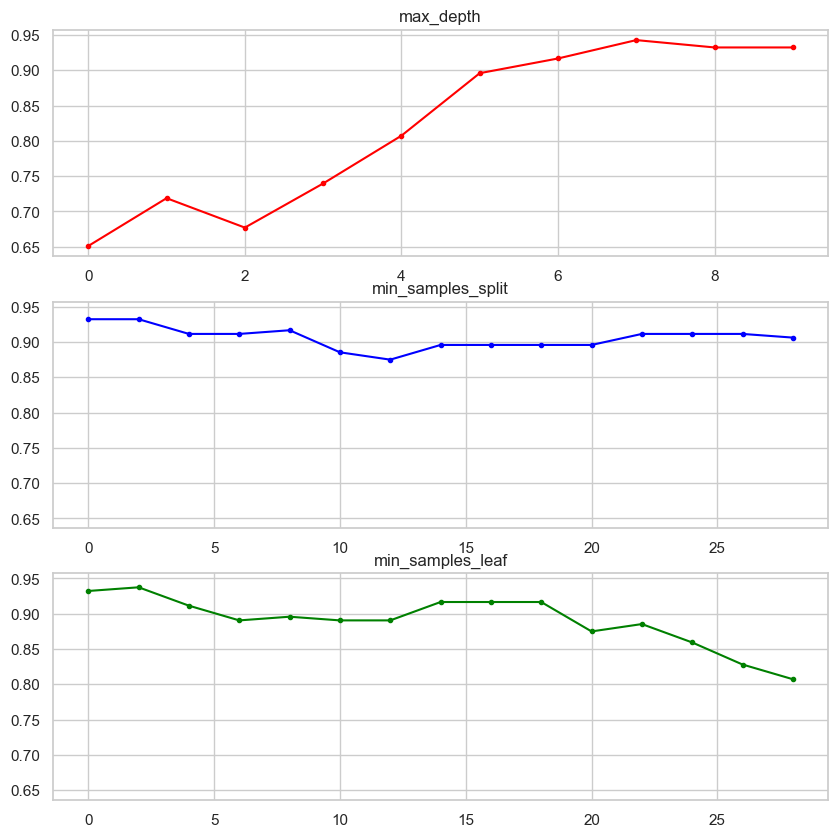

In [26]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 10), sharey=True)

ax[0].plot(max_depths, acc_depths, color="red", marker=".")
ax[0].set_title("max_depth")

ax[1].plot(min_samples_splits, acc_samples_splits, color="blue", marker=".")
ax[1].set_title("min_samples_split")

ax[2].plot(min_samples_leaves, acc_samples_leaves, color="green", marker=".")
ax[2].set_title("min_samples_leaf")

### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [27]:
oe = OrdinalEncoder()
oe.set_output(transform="pandas")

OrdinalEncoder()

In [28]:
df_tic_tac = pd.read_csv("tic-tac-toe.data", names=[f"col_{i}" for i in range(9)] + ["target"])
df_tic_tac = oe.fit_transform(df_tic_tac)
display(df_tic_tac.head())
df_tic_tac.shape

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,target
0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0
1,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0
2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0
3,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0
4,2.0,2.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0


(958, 10)

In [30]:
df_cars = pd.read_csv("car.data", names=[f"col_{i}" for i in range(6)] + ["target"])
df_cars.loc[df_cars.target == "unacc", "target"] = "acc"
df_cars.loc[df_cars.target == "good", "target"] = "vgood"
df_cars = oe.fit_transform(df_cars)
display(df_cars.head())
df_cars.shape

,col_0,col_1,col_2,col_3,col_4,col_5,target
0,3.0,3.0,0.0,0.0,2.0,1.0,0.0
1,3.0,3.0,0.0,0.0,2.0,2.0,0.0
2,3.0,3.0,0.0,0.0,2.0,0.0,0.0
3,3.0,3.0,0.0,0.0,1.0,1.0,0.0
4,3.0,3.0,0.0,0.0,1.0,2.0,0.0


(1728, 7)

In [31]:
df_nurs = pd.read_csv("nursery.data", names=[f"col_{i}" for i in range(8)] + ["target"])
df_nurs.loc[df_nurs.target == "not_recom", "target"] = "recommend"
df_nurs.loc[df_nurs.target == "very_recom", "target"] = "priority"
df_nurs.loc[df_nurs.target == "spec_prior", "target"] = "priority"
df_nurs = oe.fit_transform(df_nurs)
display(df_nurs.head())
df_nurs.shape

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,target
0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
4,2.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


(12960, 9)

In [33]:
datasets = zip(["mushrooms", "tic-tac", "cars", "nursery"],[df_mush, df_tic_tac, df_cars, df_nurs])

df_res = pd.DataFrame(columns=["model_1", "model_2", "model_3", "model_4"])

ohe = OneHotEncoder(sparse_output=False)

for dataset_name, df in tqdm(datasets):
    features_ind = df.columns.values != "target"
    features = df.columns.values[features_ind]
    target = "target"
    X = df[features].values
    y = df[target].values
    
    # model 1
    dt = DecisionTree(feature_types=["real"] * X.shape[1])
    res1 = np.mean(cross_val_score(dt, X, y, scoring="accuracy", cv=10, n_jobs=5))
    
    # model 2
    dt = DecisionTree(feature_types=["categorical"] * X.shape[1])
    res2 = np.mean(cross_val_score(dt, X, y, scoring="accuracy", cv=10, n_jobs=5))
    
    # model 3
    X_one_hot = ohe.fit_transform(X)
    dt = DecisionTree( feature_types=["real"] * X_one_hot.shape[1])
    res3 = np.mean(cross_val_score(dt, X_one_hot, y, scoring="accuracy", cv=10, n_jobs=5))

    # model 4
    dt = DecisionTreeClassifier()
    res4 = np.mean(cross_val_score(dt, X, y, scoring="accuracy", cv=10, n_jobs=5))
    df_res.loc[dataset_name] = [res1, res2, res3, res4]
    gc.collect()
    

4it [00:06,  1.71s/it]


In [34]:
df_res

,model_1,model_2,model_3,model_4
mushrooms,0.999261,1.000000,0.999631,0.956689
tic-tac,0.467533,0.541458,0.543575,0.781075
cars,0.942647,0.967546,0.919495,0.943285
nursery,0.999691,0.999537,0.999537,0.999691


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

Алгоритмы демонстрируют схожие результаты по ранжированию. В 3 из 4 случаев лучшей моделью оказывается наша реализация дерева, которая рассматривает все признаки как категориальные. Это показывает, насколько важна корректная обработка признаков моделью (в отличие от DecisionTreeClassifier из sklearn, который не поддерживает работу с категориальными признаками). Однако на датасете tic-tac-toe наши модели значительно уступают в качестве модели из sklearn. Скорее всего, это связано с тем, что наши модели без регуляризации склонны к сильному переобучению, тогда как в DecisionTreeClassifier по умолчанию применяется регуляризация.

Не совсем понятно, какую именно случайность требуется обнаружить в данных... Данные статичны и не подвержены изменениям :)


# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

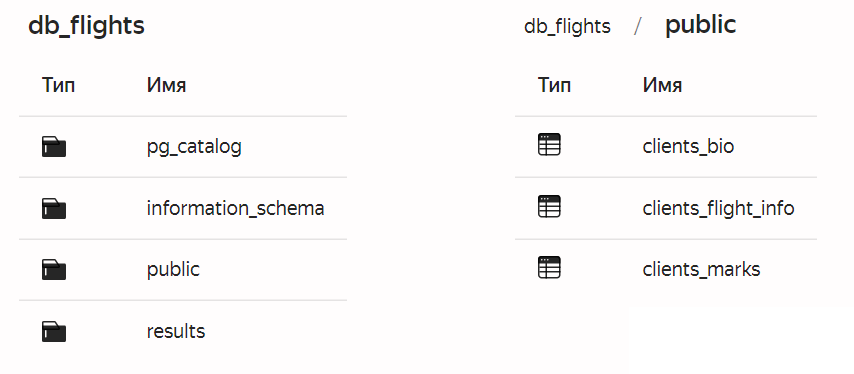

In [ ]:
conn = psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port=6432,
    sslmode="verify-full",
    dbname="db_flights",
    user="mlhs_student",
    password="mlhs_student",
    target_session_attrs="read-write"
)

In [40]:
query = """SELECT marks.id, marks."Inflight wifi service", marks."Departure/Arrival time convenient", marks."Ease of Online booking", marks."Gate location",
marks."Food and drink", marks."Online boarding", marks."Seat comfort", marks."Inflight entertainment",
marks."On-board service", marks."Leg room service", marks."Baggage handling", marks."Checkin service",
marks."Inflight service", marks."cleanliness", marks."satisfaction", bio.gender, bio.age,
flight_info."Customer Type", flight_info."Type of Travel", flight_info."class",
flight_info."Flight Distance", flight_info."Departure Delay in Minutes", flight_info."Arrival Delay in Minutes"

FROM public.clients_marks as marks
INNER JOIN public.clients_bio as bio ON marks.id = bio.id 
INNER JOIN public.clients_flight_info as flight_info ON flight_info.id = marks.id"""


In [29]:
df = pd.read_sql(query, conn).set_index("id")

In [30]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [31]:
df_train = df[df.satisfaction != '-']

df_train.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,cleanliness,satisfaction,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
id,,,,,,,,,,,,,,,,,,,,,
7,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,satisfied,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0
13,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,...,5.0,neutral or dissatisfied,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0
18,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,...,1.0,neutral or dissatisfied,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0
31,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,...,2.0,neutral or dissatisfied,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0
39,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,...,5.0,satisfied,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0


In [32]:
assert df_train.shape == (103_644, 23)

In [33]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,Inflight service,cleanliness,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
id,,,,,,,,,,,,,,,,,,,,,
55,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,2.0,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0
79,5.0,4.0,0.0,3.0,4.0,4.0,4.0,3.0,3.0,0.0,...,3.0,5.0,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0
126,2.0,5.0,2.0,4.0,5.0,2.0,5.0,5.0,3.0,5.0,...,5.0,5.0,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0
199,4.0,4.0,4.0,4.0,2.0,4.0,5.0,4.0,4.0,4.0,...,4.0,5.0,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0
263,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,...,2.0,1.0,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0


In [34]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [35]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)


In [36]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

#### Преобразуем числовые столбцы

In [37]:
num_feats = []
cat_feats = []

for col in X_train.columns:
    try:
        # numeric columns
        X_train[col] = X_train[col].astype(float)
        X_val[col] = X_val[col].astype(float)
        num_feats.append(col)
    except ValueError:
        cat_feats.append(col)
        
print("Numeric features:", num_feats, end="\n\n")
print("Categorical features:", cat_feats)

Numeric features: ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness', 'age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

Categorical features: ['gender', 'Customer Type', 'Type of Travel', 'class']


#### Найдем столбцы с пропусками

In [38]:
for col in num_feats + cat_feats:
    nan_count = X_train[col].isna().sum()
    
    if nan_count > 0:
        print(f"Feature {col} has {nan_count} Nones.")

Feature Inflight wifi service has 23 Nones.
Feature Departure/Arrival time convenient has 28 Nones.
Feature Ease of Online booking has 24 Nones.
Feature Gate location has 19 Nones.
Feature Food and drink has 22 Nones.
Feature Online boarding has 23 Nones.
Feature Seat comfort has 23 Nones.
Feature Inflight entertainment has 30 Nones.
Feature On-board service has 23 Nones.
Feature Leg room service has 22 Nones.
Feature Baggage handling has 21 Nones.
Feature Checkin service has 22 Nones.
Feature Inflight service has 30 Nones.
Feature cleanliness has 21 Nones.
Feature age has 185 Nones.
Feature Flight Distance has 54 Nones.
Feature Departure Delay in Minutes has 61 Nones.
Feature Arrival Delay in Minutes has 294 Nones.


#### Заполним пропуски

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

imputer_num = SimpleImputer(strategy="most_frequent")
imputer_num.set_output(transform="pandas")

imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.set_output(transform="pandas")

X_train[num_feats] = imputer_num.fit_transform(X_train[num_feats])
X_train[cat_feats] = imputer_cat.fit_transform(X_train[cat_feats])

X_val[num_feats] = imputer_num.transform(X_val[num_feats])
X_val[cat_feats] = imputer_cat.transform(X_val[cat_feats])

#### Избавимся от выбросов в числовых колонках, клипанув их до 1-ого и 99-ого перцентиля. 

In [40]:
for col in num_feats:
    lower_bound, upper_bound = np.percentile(X_train[col], [1, 99])
    X_train.loc[X_train[col] < lower_bound, col] = lower_bound
    X_train.loc[X_train[col] > upper_bound, col] = upper_bound

In [41]:
print("Statistics of num features")
display(X_train.describe().T)

print("Statistics of cat features")
display(X_train.describe(include="object").T)

Statistics of num features


,count,mean,std,min,25%,50%,75%,max
Inflight wifi service,72550.0,2.730448,1.330097,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,72550.0,3.061778,1.524762,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,72550.0,2.758704,1.399822,0.0,2.0,3.0,4.0,5.0
Gate location,72550.0,2.978608,1.278850,1.0,2.0,3.0,4.0,5.0
Food and drink,72550.0,3.208132,1.327486,1.0,2.0,3.0,4.0,5.0
Online boarding,72550.0,3.253618,1.349279,0.0,2.0,3.0,4.0,5.0
Seat comfort,72550.0,3.442646,1.317133,1.0,2.0,4.0,5.0,5.0
Inflight entertainment,72550.0,3.359490,1.333277,1.0,2.0,4.0,4.0,5.0
On-board service,72550.0,3.379545,1.289551,1.0,2.0,4.0,4.0,5.0
Leg room service,72550.0,3.352378,1.306297,1.0,2.0,4.0,4.0,5.0


Statistics of cat features


,count,unique,top,freq
gender,72550,2,Female,36816
Customer Type,72550,3,Loyal Customer,59354
Type of Travel,72550,3,Business travel,49984
class,72550,4,Business,34727


**Вывод о распределении признаков**
1. Работа с выбросами помогла нам получить адекватные распределния числовых фичей. Колонки, относящиеся к оценкам, лежат в интервале [0, 5].  Их распределения примерно центрированы. Распределение колонки `age` так же похоже на нормальное. Однако распределение колонок `Flight Distance`, `Departure Delay in Minutes`, `Arrival Delay in Minutes` имеет длинный правый хвост (50prct << max). Данные колонки необходимо отлогарифмировать, чтобы привести их распределение к нормальному. 

2. Категориальные признаки не содержат много классов и экстримально маленьких/больших категорий. Пригодны для использования в моделях.

### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

Как уже упоминалось, применим логарифмирование к признакам Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes.

Проведем нормировку с помощью StandardScaler.

На мой взгляд, это стандартный пайплайн. Дополнительные шаги избыточны (даже нормировка, так как деревья способны работать с признаками любого распределения).

Категориальные признаки

Используем OrdinalEncoding 
Здесь выбор невелик: OrdinalEncoding, TargetEncoding или OneHotEncoding. В литературе уже давно рекомендуется отдавать предпочтение OrdinalEncoding перед OneHotEncoding при работе с деревьями пример. Применение TargetEncoding приведет к тому, что все категориальные признаки будут рассматриваться как числовые, что исключит возможность осмысленного разделения по конкретным категориям. Кроме того, возрастает риск переобучения модели. (Вообще, TargetEncoding чаще всего используется в моделях, которые не поддерживают работу с категориальными признаками, например, LogReg или SVM.)

Остается OrdinalEncoding. Этот метод кодирования категориальных признаков является базовым при работе с деревьями.

In [42]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [43]:
X_train[["Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]] = np.log(X_train[["Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]] + 1)
X_val[["Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]] = np.log(X_val[["Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]] + 1)
ct = ColumnTransformer(
    [("categorical", OrdinalEncoder(dtype=int), cat_feats), ("numeric", StandardScaler(), num_feats) ] , n_jobs=3, verbose_feature_names_out=False)
ct.set_output(transform="pandas")

X_train = ct.fit_transform(X_train)
X_val = ct.fit_transform(X_val)


### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [44]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [45]:
dt = DecisionTree(
    feature_types=["categorical"] * len(cat_feats) + ["real"] * len(num_feats), max_depth=5
)
dt.fit(X_train.values, y_train)
y_tree_pred = dt.predict(X_val.values)
print(f"Our decision tree: {f1_score(y_val, y_tree_pred): .3f}")

Our decision tree:  0.891


In [47]:
rf = RandomForestClassifier(random_state=77, n_jobs=4)
rf.fit(X_train.values, y_train)
y_rf_pred = rf.predict(X_val.values)
print(f"Random forest: {f1_score(y_val, y_rf_pred): .3f}")

Random forest:  0.953


Очевидно **Random Forest** лучше, т.к это много деревьев)

### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform

In [57]:
# our tree
feature_types = ["categorical"] * len(cat_feats) + ["real"] * len(num_feats)
dt = DecisionTree(feature_types=feature_types)

search = RandomizedSearchCV(
    dt,{"max_depth": [1, 2, 3, 4, 5, 6],"min_samples_split": uniform(loc=0, scale=30),"min_samples_leaf": uniform(loc=0, scale=30) },
    scoring="f1", cv=3, random_state=5252,error_score='raise',verbose=3, n_jobs=4)

# subsample train for faster compute
search.fit(X_train.values[:50_000], y_train[:50_000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=DecisionTree(feature_types=['categorical',
                                                         'categorical',
                                                         'categorical',
                                                         'categorical', 'real',
                                                         'real', 'real', 'real',
                                                         'real', 'real', 'real',
                                                         'real', 'real', 'real',
                                                         'real', 'real', 'real',
                                                         'real', 'real', 'real',
                                                         'real', 'real']),
                   n_jobs=4,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x29b2c04c0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a1668100>},
                   random_state=77, scoring='f1', verbose=3)

In [64]:
print("Found best params:", search.best_params_)

Found best params: {'max_depth': 5, 'min_samples_leaf': 10.601305683041861, 'min_samples_split': 1.2019249363201623}


In [91]:
rf = RandomForestClassifier(random_state=5252)
search = RandomizedSearchCV(
    rf,
    {"min_samples_split": np.arange(2, 10),"min_samples_leaf": np.arange(1, 10),"max_features": uniform(loc=0.8, scale=0.2),"n_estimators": [150, 200]},
    scoring="f1",cv=3, random_state=5252,error_score='raise',verbose=3,n_jobs=6)

search.fit(X_train.values, y_train)
print("Found best params:", search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Found best params: {'max_features': 0.859230912806672, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 150}


**Fitting best models**

In [93]:
dt = DecisionTree(
    feature_types=feature_types,
    max_depth=5,
    min_samples_leaf=10.601305683041861,
    min_samples_split=1.2019249363201623,
)
dt.fit(X_train.values, y_train)
y_tree_pred = dt.predict(X_val.values)
print(f"Our decision tree with tuned params: {f1_score(y_val, y_tree_pred): .3f}")


rf = RandomForestClassifier(
    random_state=77, n_jobs=4,
    max_features=0.859230912806672,
    min_samples_leaf=2,
    min_samples_split=3,
    n_estimators=150
)
rf.fit(X_train.values, y_train)
y_rf_pred = rf.predict(X_val.values)
print(f"Random forest with tuned params: {f1_score(y_val, y_rf_pred): .3f}")

Our decision tree with tuned params:  0.891
Random forest with tuned params:  0.954


**Best model** - **Random Forest with tuned params**

In [95]:
import pickle

with open("data/tuned_random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [99]:
feat_imp = pd.DataFrame().assign(
    feat=X_train.columns, imp=rf.feature_importances_
).sort_values(by="imp", ascending=False)

<Axes: xlabel='feat', ylabel='imp'>

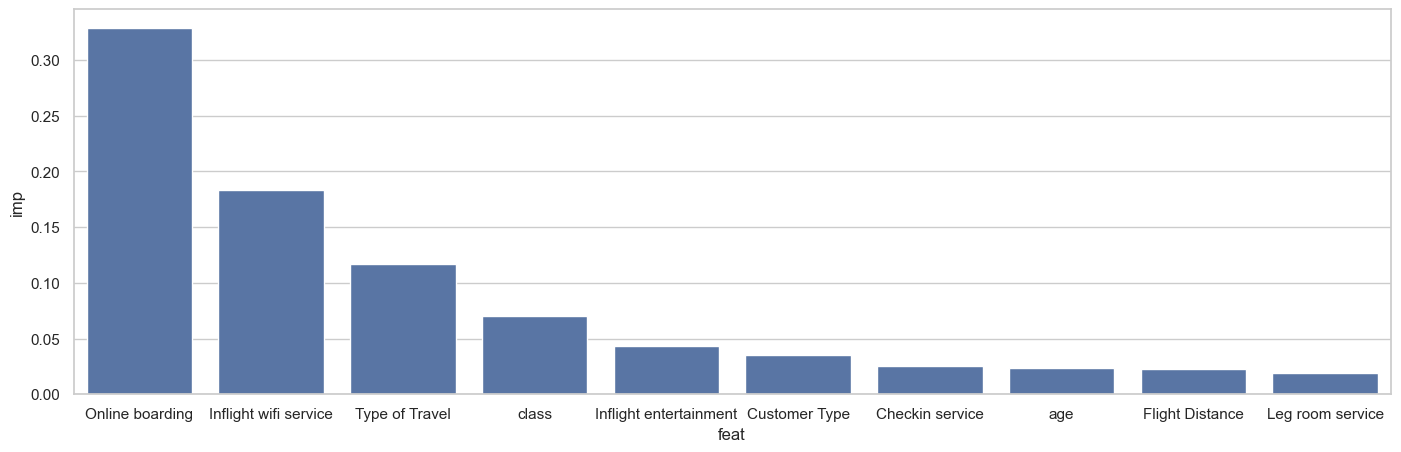

In [107]:
fig, ax = plt.subplots(figsize=(17, 5))
sns.barplot(feat_imp.iloc[:10], x="feat", y="imp", ax=ax)

**Наиболее важные признаки:**
* Оценка онлайн бронирования 
* Оценка wi-fi на борту
* Тип поездки
* Класс обслуживания 
* Оценка системы развлечений на борту
* Тип клиента 

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [128]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_val.sample(1000, random_state=77))

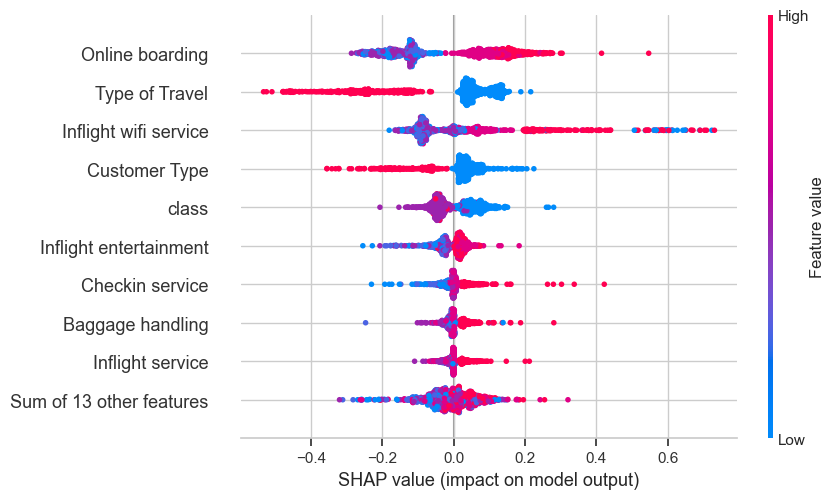

In [138]:
shap.plots.beeswarm(shap_values[:, :, 1])

In [169]:
most_imp_shap_feats = X_train.columns[np.argsort(
    -1 * np.sum(np.abs(shap_values.values[:, :, 1]), axis=0)
)[:5]].values

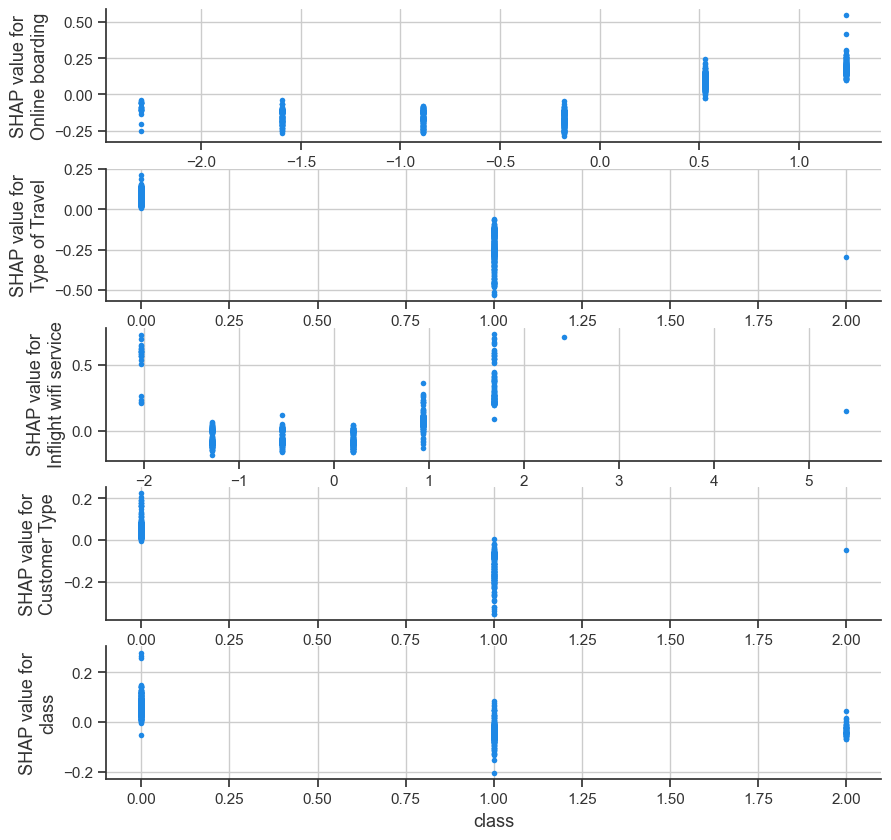

In [172]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 10))
for i, feat in enumerate(most_imp_shap_feats):
    shap.dependence_plot(feat, shap_values.values[:, :, 1],
                         X_val.sample(1000, random_state=77),
                         ax=ax[i], show=False, interaction_index=None)
    

Наибольшее значение SHAP имеет признак Online boarding. Чем выше оценка этого признака, тем выше вероятность, что пассажир останется доволен полетом.

На втором месте по важности SHAP находится признак Type of Travel. Пассажиры чаще удовлетворены полетами бизнес-класса (Type of Travel = 0).

Третьим по значимости SHAP является признак Inflight wifi service. Чем выше его оценка, тем больше вероятность положительного впечатления от полета.

В целом, важность признаков, определенная с помощью SHAP, совпадает с результатами, полученными в предыдущем пункте.

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [187]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    X_val.values,
    mode="classification",
    feature_names=X_val.columns
)

explainer

In [195]:
explanation = explainer.explain_instance(X_val.values[0], rf.predict_proba)
explanation.show_in_notebook()

Признаки с наибольшим вкладом в предсказание:

Type of Travel = 0 (бизнес-класс) повышает вероятность положительной оценки поездки на 0.39.

Customer Type = Loyal Customer увеличивает вероятность того, что поездка понравится, на 0.23.

Низкая оценка Inflight wifi service негативно влияет на оценку поездки, снижая вероятность положительного впечатления на 0.09.

Описание полученного графика:

В левой части отображены вероятности классов:

Класс 0 (0.02): низкая вероятность.

Класс 1 (0.98): высокая вероятность — модель уверена в своем предсказании.

В центральной части представлен график с признаками, которые внесли наибольший вклад в предсказание. Их интерпретация приведена выше.

В правой части показаны значения признаков.

В целом, график демонстрирует, что модель с уверенностью 98% предсказывает, что полет понравится. Ключевыми признаками, повлиявшими на это, стали Type of Travel, Customer Type и Inflight wifi service. Признаки, такие как Checkin service и Seat comfort, хоть и оказывали влияние в сторону отрицательной оценки, их вклад оказался недостаточным для изменения итогового результата.

## Котобонус!

0.25 балла

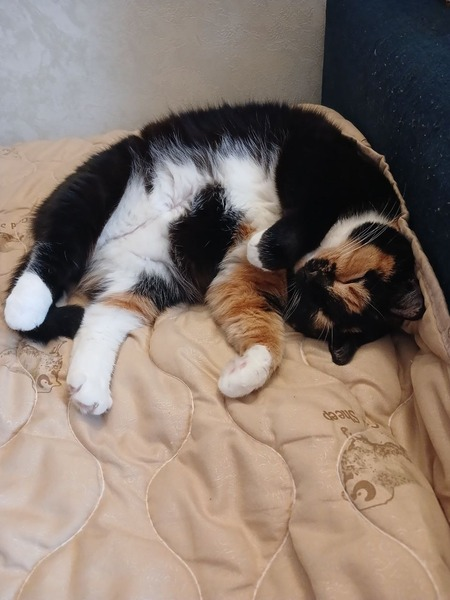

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?